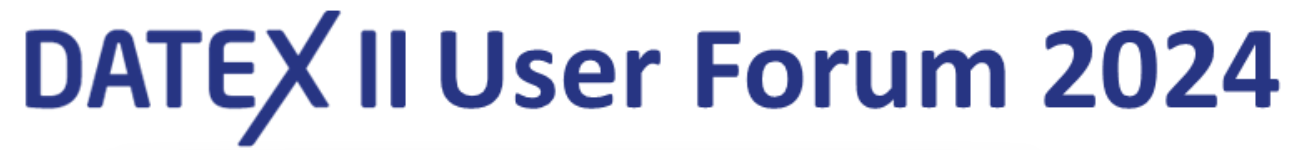<br>
# <center>Exploring the future of DATEX II</center>
# <center>Demo session on Version 4</center>

<br>
<br>
For this demonstration, a SituationPublication model was created for DATEX II version 4. It uses the new D2Entity Stereotype for SituationRecord.
A server for demo purposes can answer API requests on the Accident-Object and return accidents within an given position with radius (based on a set of virtual accidents).
<br><br>
The necessary Python code is created with OpenAPI using a customised YAML-file.

#### Limitations of the demo
 - The current v4 test environment does not support the stereotypes D2EntityIdentifiable or D2VersionedIdentifiable. Thus the stereotype D2Entity will be used for test purposes
 - The v4 Situation model is currently under development. The model used is a simple transformation from v3, but will not reflect any upcoming model changes.
 - The special demo-version of the DATEX Webtool as well as the demonstration-server will be available also afterwards for testing at home for the participants of the User Forum

## Generating Python code from OpenAPI

For this demo we use [openAPI Generator](https://openapi-generator.tech/) for code generation. If you want to test it out yourself follow the installation instructions.

The next step is to do the code generation from the DATEX II JSON Schema Definition (*.json) files.
We create the code from:
-  the top-level umbrella schema for DATEX II (DATEXII_4_D2Payload.json)
-  the DATEX II Common library (DATEXII_4_Common.json)
-  the DATEX II LocationReferencing library (DATEXII_4_LocationReferencing.json)
-  the DATEX II Situation namespace (DATEXII_4_Situation.json)

These can be created from the Situation DATEX II model, using the [DATEX II online schema generation tool](https://datexfutureexample.azurewebsites.net/wizard/).
<i>Note that this is a specific demo version for v4. The regular Tool for v3 can be found [here](https://webtool.datex2.eu/).</i><br><br>
Just follow the Wizard using the proposed v4 model:<br><br>
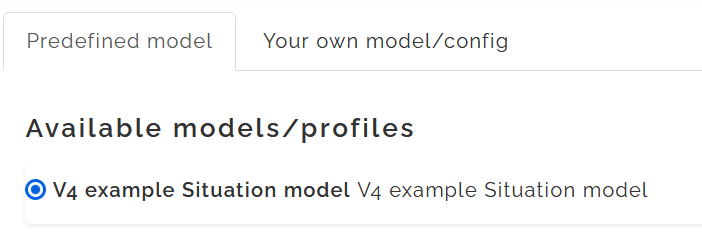

In the tree-selection phase, you can first deselet everything (by deselecting PayloadPublication) and afterwards going for PayloadPublication - SituationPublication situation - Situation - In the tree-selection phase, you can first deselet everything (by deselecting PayloadPublication) and afterwards going for `PayloadPublication - SituationPublication - situation - Situation - situationRecord - SituationRecord - TrafficElement - Accident`:

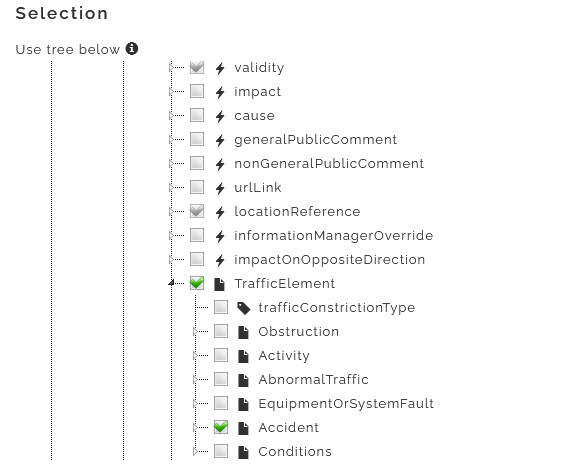
<br><br>
Copy the resulting .json files in the same directory than your .jar for the openapi-generator.

Now you can now create the Python code from the DATEX II schema files by running the following command in the command prompt:

`java -jar openapi-generator-cli-7.9.0.jar generate -g python -o generated -i DATEX_II_v4-Demo_OpenApi.yaml`

This will create a "generated" directory with Python code inside.
Be sure to put the "generated" folder within the same folder than this notebook file.

## Prerequisites

Importing some libraries:

In [ ]:
import sys
import os
# print(os.path.abspath('../Jupyter/generated'))
sys.path.insert(0, os.path.abspath('../Jupyter/generated'))
!{sys.executable} -m pip install ipyleaflet

## Working with the data

Connecting to the demo server and making the accidents-by-radius request:

In [ ]:
import openapi_client
from openapi_client.rest import ApiException
from pprint import pprint

In [ ]:
# Defining the host is optional and defaults to https://v4futureapi.azurewebsites.net
# See configuration.py for a list of all supported configuration parameters.
configuration = openapi_client.Configuration(
    host = "https://v4futureapi.azurewebsites.net"
)

In [ ]:
# Enter a context with an instance of the API client
with openapi_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    api_instance = openapi_client.DefaultApi(api_client)
    latitude = 53.476531 # float | Degree of latitude of the accident site.
    longitude = -2.328261 # float | Degree of longitude of the accident site.
    radius = 3000 # float | 
   
    try:
        api_response = api_instance.get_accidents_by_radius_get(latitude, longitude, radius, accident_type='accident')
        print("The response of DefaultApi->get_accidents_by_radius_get:\n")
        pprint(api_response)
    except ApiException as e:
        print("Exception when calling DefaultApi->get_accidents_by_radius_get: %s\n" % e)

<br>
Evaluating the resulting list of accidents:

In [ ]:
import pandas as pd
data = pd.DataFrame(columns=['type','longitude','latitude'])

In [ ]:
i=0
for accident in api_response:
    type = accident.accident_type[0].value.value
    lat = accident.location_reference['locPointLocation']['pointByCoordinates']['pointCoordinates']['latitude']
    lon = accident.location_reference['locPointLocation']['pointByCoordinates']['pointCoordinates']['longitude']

    temp = pd.DataFrame({'type':type,
                         'longitude':[lon],
                         'latitude':[lat]},
                         index=([i]))
    df_list = filter(lambda x: not x.empty, [data,temp])
    data = pd.concat(list(df_list), axis=0)
    i=i+1

<br>
Plotting data points on a map:

In [ ]:
from ipyleaflet import Icon, Map, Marker, AwesomeIcon
center = (51, 10)
m = Map(center=center, zoom=3)

icon_1 = AwesomeIcon(name='fa-exclamation-triangle', marker_color='red')
icon_2 = AwesomeIcon(name='fa-truck', marker_color='red')

for i in data.index:
    if data['type'][i] == 'accidentInvolvingHazardousMaterials':
        data.at[i,'marker'] = icon_2
    else:
        data.at[i,'marker'] = icon_1

for i in data.index:
    marker = Marker(location=(data['latitude'][i],data['longitude'][i]), icon=data['marker'][i], title=data['type'][i], draggable=False)
    m.add(marker)
m